# Allen Institute
## 07_fa_m1_10x
---
### Dataset
- `../data/m1_10x_resampled/resampled`

1. Data Viz
2. Factor Analysis

In [1]:
import os
from itertools import product
import json
from typing import NamedTuple, Dict, Union

import factor_analyzer as fa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from tqdm.notebook import tqdm

from tools.factor_analysis import kmo_viz, parallel_analysis, plot_parallel_analysis, FactorAnalyzer
from tools.figure import boxplot, fa_preset, fig_kwarg
from tools.r import read_json
from tools.sklearn_wrapper import KMeansClustering
import tools.spongy_panda as spd

In [2]:
class Config(NamedTuple):
    data: pd.core.frame.DataFrame = spd.log2normalize(
        spd.load_10xdir(
            "../data/m1_10x_resampled/resampled", from_r=True
        ).loc[:, fa_preset]
    ).to_df()
    umap: pd.core.frame.DataFrame = pd.read_pickle(
        "../data/m1_10x_viz/umap.pkl"
    )
    save_dir: str = "../out/m1_10x/07_fa"
    fig_kwarg: Dict[str, Union[str, int, float]] = fig_kwarg
    save_file: bool = False

In [3]:
conf = Config(save_file=True)

os.makedirs(conf.save_dir, exist_ok=True)

---
## Data Visualization
- heatmap
- kmo
- histogram

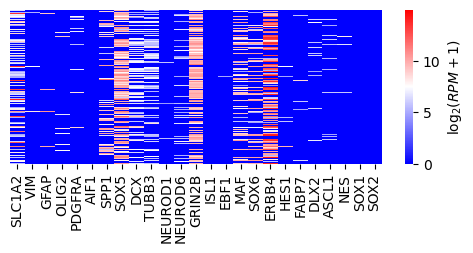

In [4]:
fig, ax = plt.subplots(figsize=(6, 2))
sns.heatmap(
    conf.data, ax=ax, cmap="bwr",
    vmax=conf.data.max().max(),
    vmin=conf.data.min().min(),
    yticklabels=False
)
ax.set(ylabel="")
ax.collections[0].colorbar.set_label("$\log_2(RPM+1)$");

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/heatmap.png", **conf.fig_kwarg)

In [5]:
data = conf.data.loc[:, conf.data.columns[conf.data.max() > 0]]

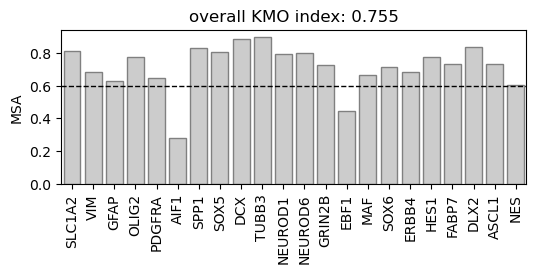

In [6]:
fig, ax = plt.subplots(figsize=(6, 2))

kmo_viz(data, ax=ax, line=True, landscape=True, **{"color": ".8"})

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/kmo.png", **conf.fig_kwarg)

In [7]:
conf = Config(
    data=data.T[fa.calculate_kmo(data)[0] > 0.6].T,
    save_file=conf.save_file
)

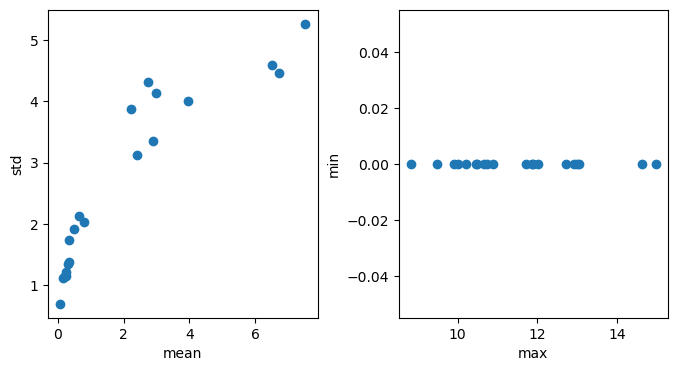

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.3)

ax[0].scatter(conf.data.mean(), conf.data.std())
ax[0].set(xlabel="mean", ylabel="std")

ax[1].scatter(conf.data.max(), conf.data.min())
ax[1].set(xlabel="max", ylabel="min");

- rescaling might not essential

---
## Factor Analysis
- parallel analysis
- factor analysis
- clustering

### Parallel Analysis

In [9]:
n_f = parallel_analysis(
    conf.data,
    random_state=0,
    nullmodel="perm",
    use_smc=True
)

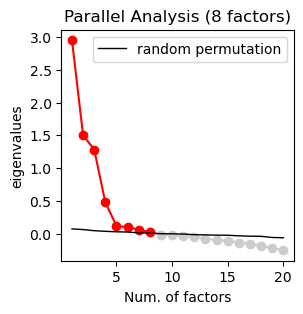

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))

plot_parallel_analysis(
    conf.data,
    random_state=0,
    nullmodel="perm",
    use_smc=True,
    ax=ax
)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/pa.png", **conf.fig_kwarg)

### Factor Analysis
- quartimin rotation
- varimax rotation

In [11]:
rot, method = "quartimin", "ml"

In [12]:
model_fa = FactorAnalyzer(n_f, conf.data)

model_fa.rotate(rot, method)

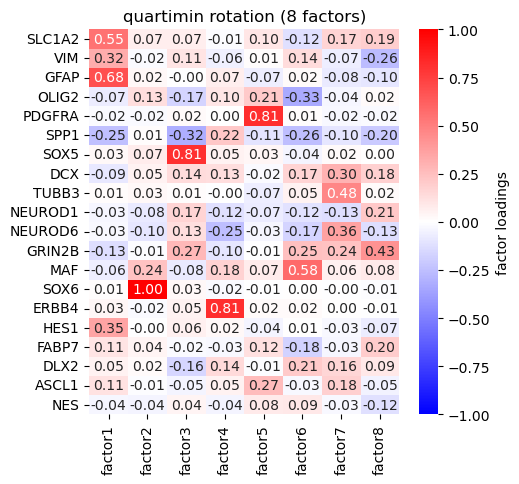

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

model_fa.heatmap(ax)
ax.set(title=f"{rot} rotation ({n_f} factors)")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/factors_{rot}_{n_f}.png", **conf.fig_kwarg)

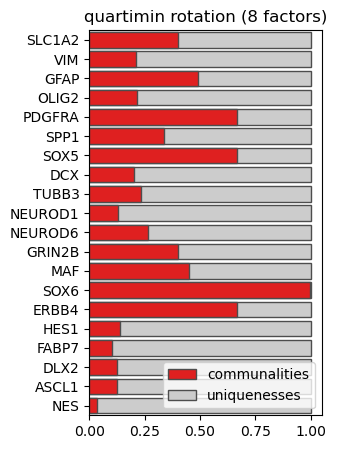

In [14]:
fig, ax = plt.subplots(figsize=(3, 5))

model_fa.plot_var(ax)
ax.set(title=f"{rot} rotation ({n_f} factors)")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/com_uni_{rot}_{n_f}.png", **conf.fig_kwarg)

- varimax rotation

In [15]:
rot = "varimax"

In [16]:
model_fa.rotate(rot, method)

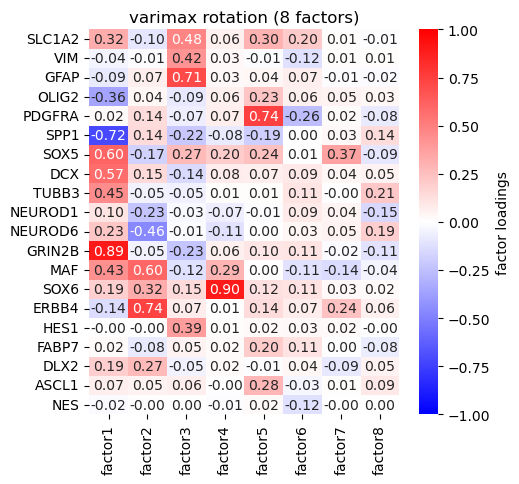

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))

model_fa.heatmap(ax)
ax.set(title=f"{rot} rotation ({n_f} factors)")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/factors_{rot}_{n_f}.png", **conf.fig_kwarg)

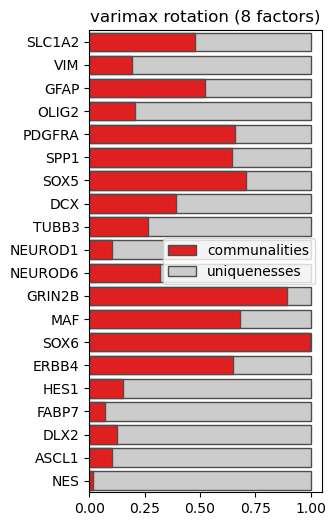

In [18]:
fig, ax = plt.subplots(figsize=(3, 6))

model_fa.plot_var(ax)
ax.set(title=f"{rot} rotation ({n_f} factors)")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/com_uni_{rot}_{n_f}.png", **conf.fig_kwarg)

### Comprehensive model selection

In [19]:
model_fa.results.keys()

dict_keys([(8, 'quartimin', 'ml'), (8, 'varimax', 'ml')])

In [20]:
res_fa = model_fa.results[(8, "quartimin", "ml")]

---
## Clustering

In [21]:
km = KMeansClustering(minimum=2, maximum=20, data=res_fa)

k-means:   0%|          | 0/19 [00:00<?, ?it/s]

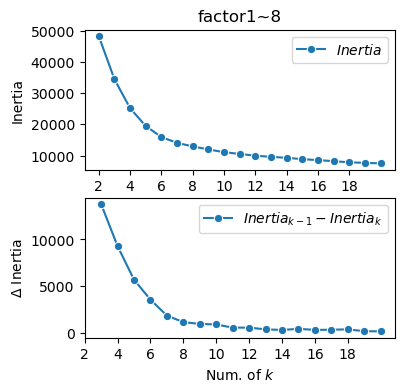

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4))

km.elbow(ax, show_diff=True)

ax[0].set(title=f"factor1~{n_f}");

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/elbow.png", **conf.fig_kwarg)

Calculating Silhouette Coeff.:   0%|          | 0/19 [00:00<?, ?it/s]

Calculating the mean:   0%|          | 0/19 [00:00<?, ?it/s]

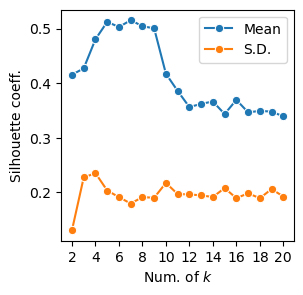

In [23]:
fig, ax = plt.subplots(figsize=(3, 3))

km.silhouette_curve(ax, show_diff=True)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/silhouette_curve.png", **conf.fig_kwarg)

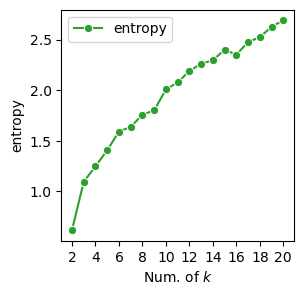

In [24]:
fig, ax = plt.subplots(figsize=(3, 3))

km.entropy_curve(ax, show_diff=True)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/entropy.png", **conf.fig_kwarg)

### Choice of optimal k

In [25]:
km.optimal_k(manual=True, k=6)

Optimal Number of k: 6


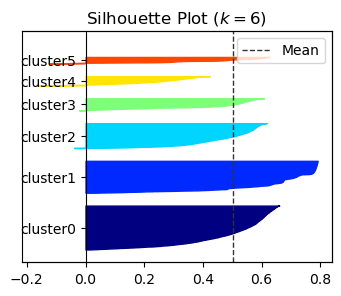

In [26]:
fig, ax = plt.subplots(figsize=(4, 3))

km.silhouette_plot(ax, cmap="jet")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/silouhette_{km.k}.png", **conf.fig_kwarg)

### Visualization

In [27]:
center = conf.umap.assign(cluster=km.label.cluster.astype(str)).groupby("cluster").median()

In [28]:
kmlc = [f"{int(v)}" for v in km.label.cluster.sort_values()]

In [29]:
sample_id = "m1_10x"

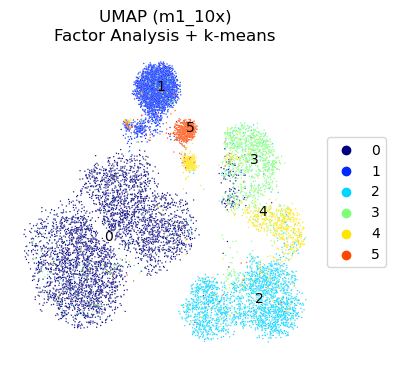

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    data=conf.umap.loc[km.label.cluster.sort_values().index, :],
    x="UMAP1", y="UMAP2", hue=kmlc,
    palette=km.cmap("jet"), ax=ax,
    s=1
)

for i, v in enumerate(center.index):
    ax.annotate("" if v == "Unclassifiable" else v, center.iloc[i, :])

ax.set(title=f"UMAP ({sample_id})\nFactor Analysis + k-means")
ax.legend(bbox_to_anchor=(1, .5), loc="center left")
ax.axis("off");

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/{sample_id}_umap.png", **conf.fig_kwarg)

Visualizing Factor Scores:   0%|          | 0/8 [00:00<?, ?it/s]

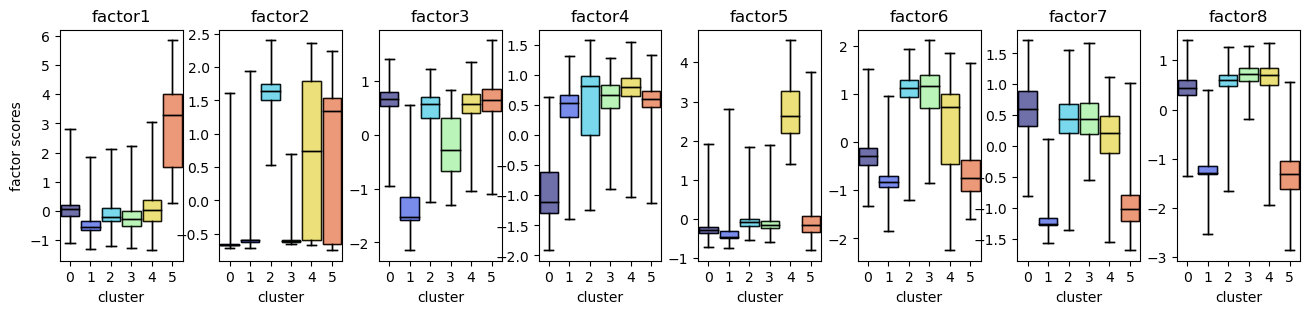

In [31]:
fig, ax = plt.subplots(1, n_f, figsize=(2 * n_f, 3))
plt.subplots_adjust(wspace=0.3)

kwargs = {"edgecolor": "k", "alpha": 0.6}

for i, v in tqdm(enumerate(km.data), desc="Visualizing Factor Scores", total=n_f):
    
    data = pd.concat([km.data.loc[:, v], km.label.cluster], axis = 1)
    
    boxplot(
        data=pd.concat([km.data, km.label.cluster], axis = 1),
        x="cluster",
        y=km.data.columns[i],
        palette=km.cmap("jet"),
        ax=ax[i],
        **kwargs
    )
    
    ax[i].set_ylabel("factor scores" if i == 0 else "")
    ax[i].set_xticklabels([k for k in range(km.k)]);
    ax[i].set(title=f"factor{i+1}", xlabel="cluster")
    
if conf.save_file:
    plt.savefig(f"{conf.save_dir}/facotrscores_{n_f}.png", **conf.fig_kwarg)

---
## Comparison of performance

In [32]:
label = pd.read_csv("../data/m1_10x_meta/metadata.csv", index_col=0).loc[km.label.index, :]

In [33]:
label_deg = pd.read_csv("../data/m1_10x_annot/m1_10x_clusters.csv", index_col=0).loc[km.label.index, :]

In [34]:
l_labels = [label.class_order, label.subclass_order, label_deg.cluster_id, km.label.cluster]

In [35]:
df_ars = pd.DataFrame(
    np.array(
        [adjusted_rand_score(*v) for v in product(l_labels, l_labels)]
    ).reshape(len(l_labels), -1),
    index = ["Metadata\n(class)", "Metadata\n(subclass)", "DEG", "FA"],
    columns = ["Metadata\n(class)", "Metadata\n(subclass)", "DEG", "FA"]
)

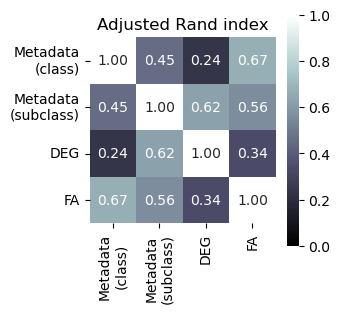

In [36]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.heatmap(
    df_ars, vmin=0, vmax=1, square=True,
    annot=True, fmt=".2f", cmap="bone"
)

ax.set(title="Adjusted Rand index");

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/{sample_id}_ari.png", **conf.fig_kwarg)

In [37]:
df_amis = pd.DataFrame(
    np.array(
        [adjusted_mutual_info_score(*v) for v in product(l_labels, l_labels)]
    ).reshape(len(l_labels), -1),
    index = ["Metadata\n(class)", "Metadata\n(subclass)", "DEG", "FA"],
    columns = ["Metadata\n(class)", "Metadata\n(subclass)", "DEG", "FA"]
)
    

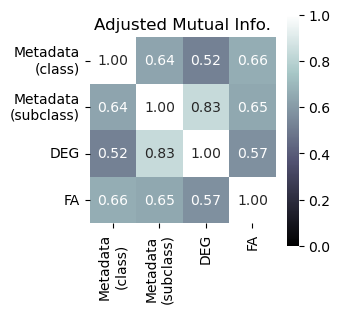

In [38]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.heatmap(
    df_amis, vmin=0, vmax=1, square=True,
    annot=True, fmt=".2f", cmap="bone"
)

ax.set(title="Adjusted Mutual Info.");

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/{sample_id}_ami.png", **conf.fig_kwarg)

---
## Export Info

In [39]:
with open(f"{conf.save_dir}/colors_{km.k}.json", mode="w") as f:

    colors = {
        i: v for i, v in enumerate(km.cmap("jet"))
    }
    json.dump(colors, f)